In [3]:
import os
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb 
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from tpot.builtins import StackingEstimator
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)
os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=UserWarning)
sklearn.set_config(print_changed_only=True)

d:\conda_date\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
result_dic = {}
models = {}

In [6]:
train_path = 'input/inputTrain.csv'
train_df = pd.read_csv(train_path)
train_df.drop(columns=['Unnamed: 0', 'carid'], inplace=True)
train_df.T

,review,label
0,When I see children on T.V from areas devastat...,3
1,In the past I used to think that my mother was...,6
2,One night I and my friends went to the cemeter...,1
3,Doctors ignored relative who complained about ...,4
4,"Having been unjustly punished, I feel disgust ...",4
...,...,...
5979,When our government decided to withdraw studen...,2
5980,Depressions.,3
5981,A friend prepared a soup with chicken heads an...,4
5982,I felt shame when I didn't study enough for my...,5


In [26]:
X = train_df.drop(columns='price').to_numpy()
y = train_df['price'].values

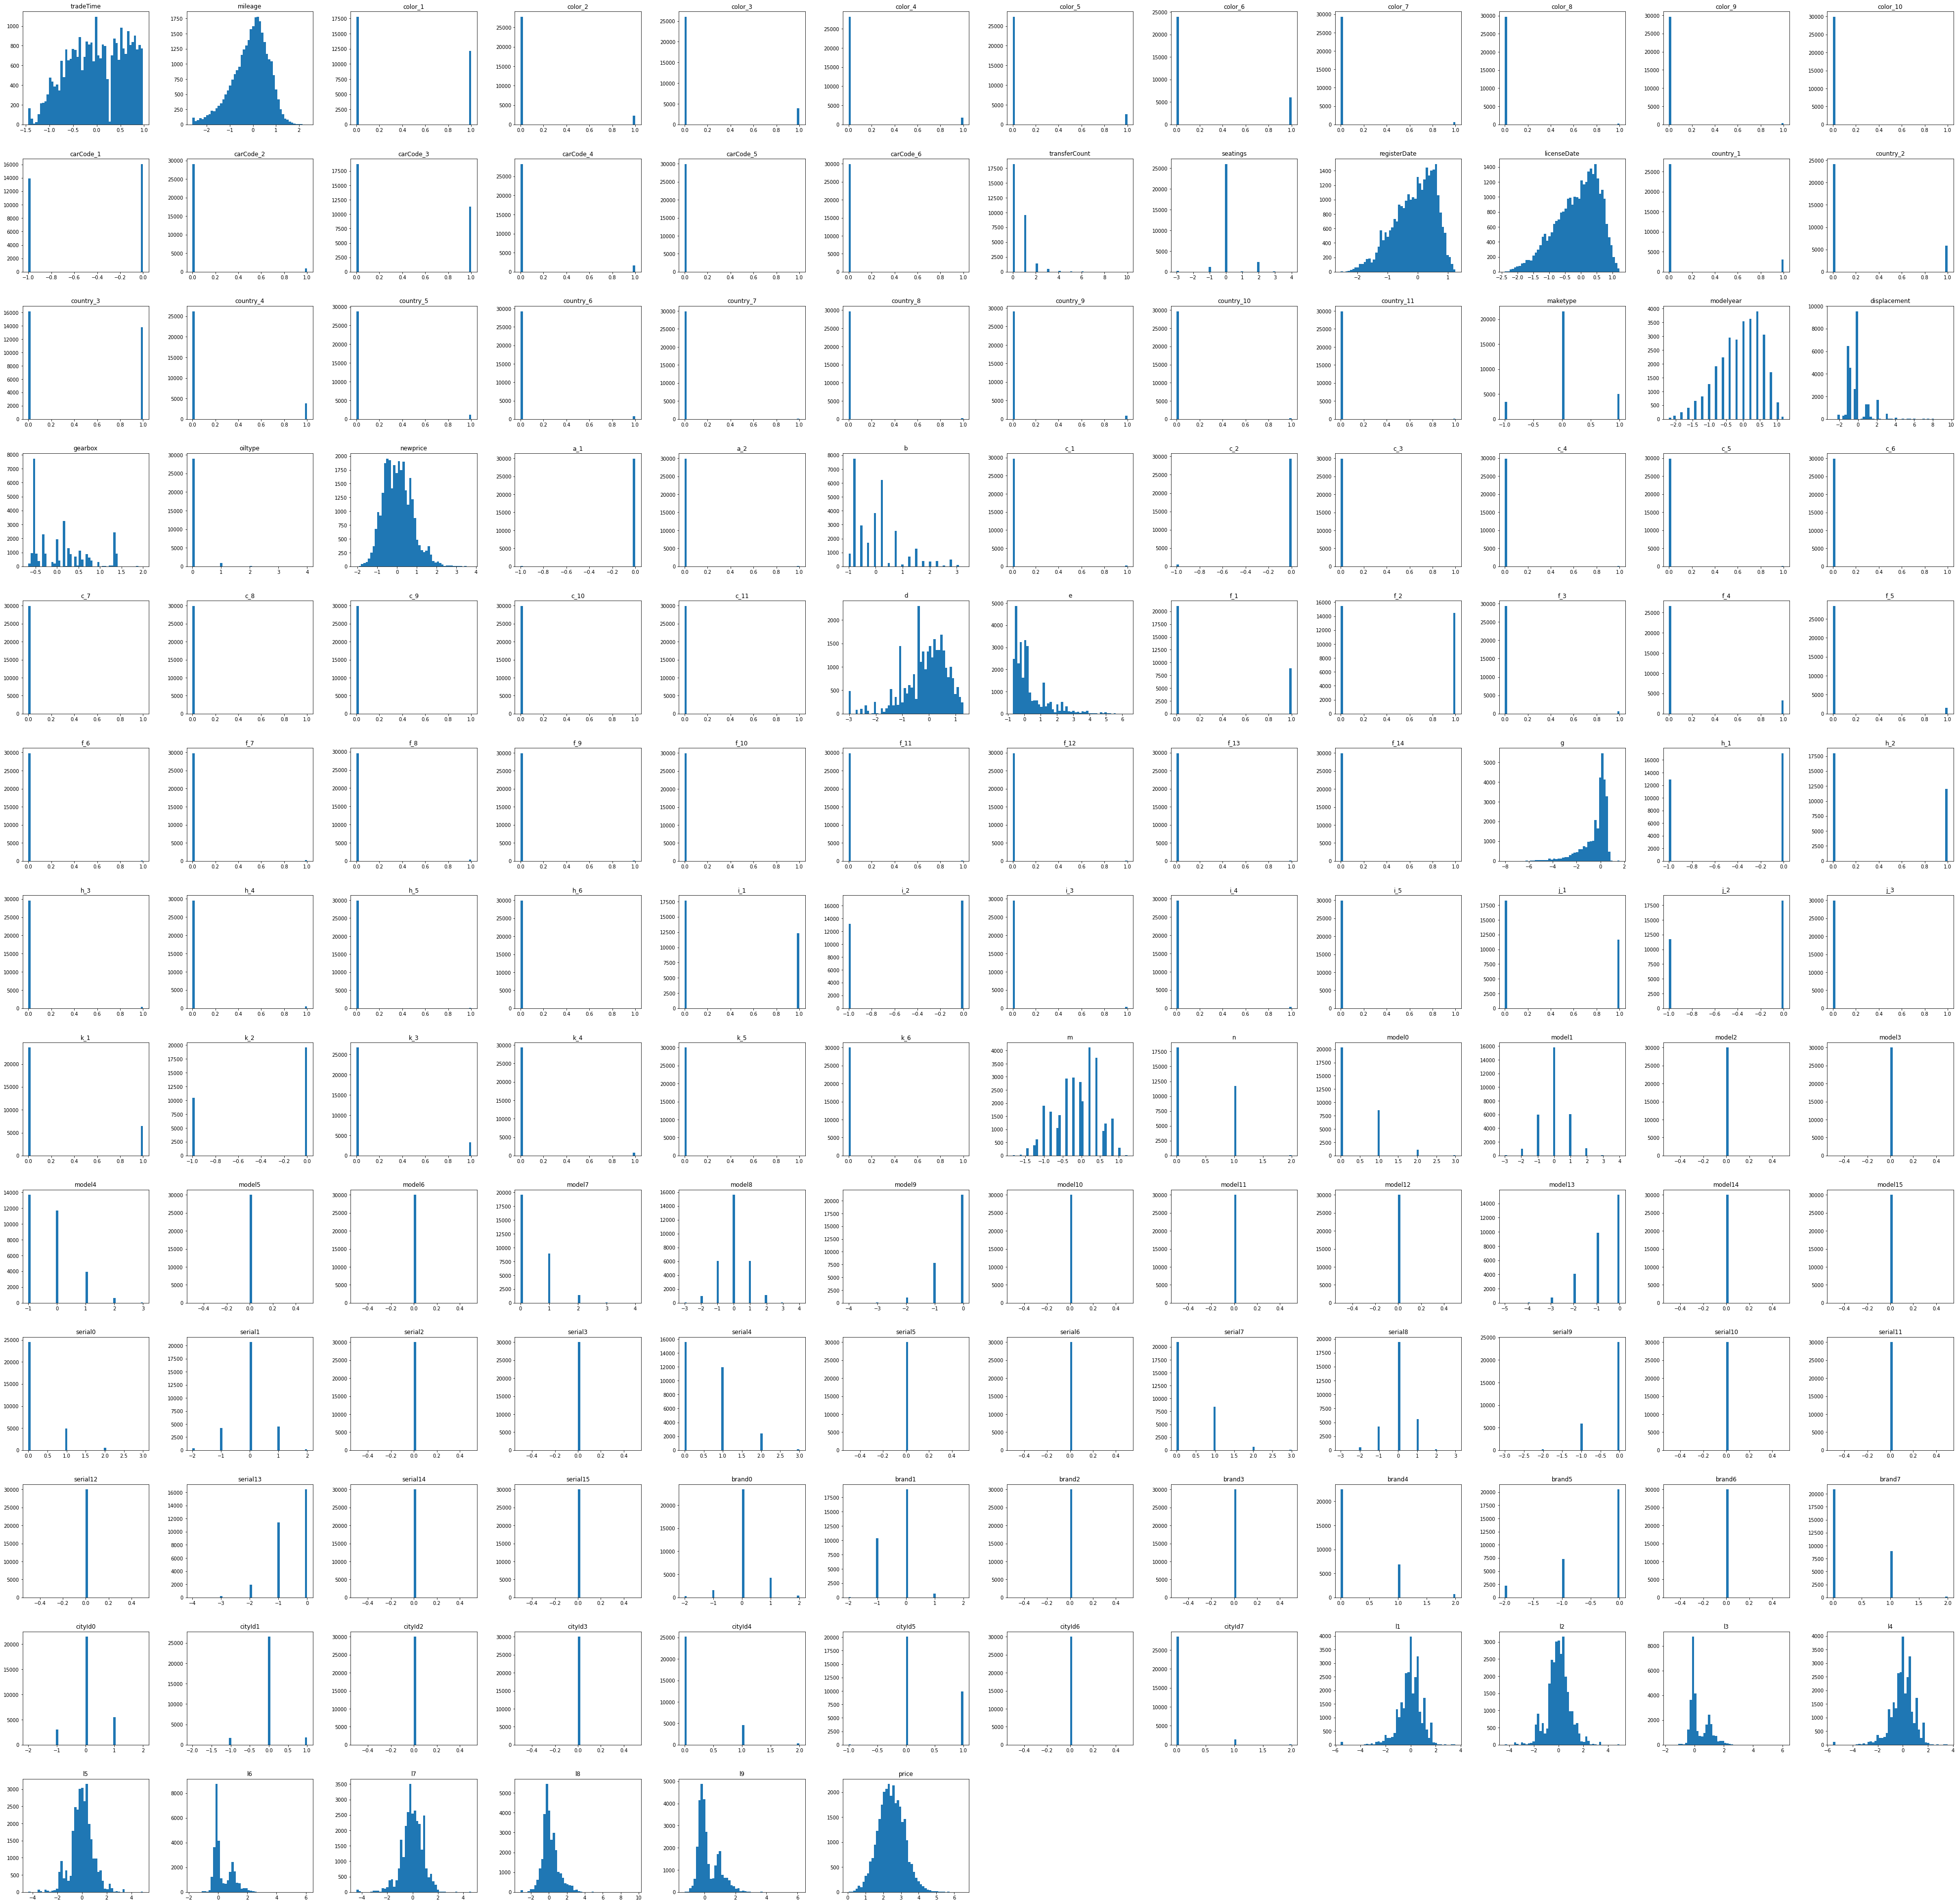

In [27]:
num_bins = int(np.floor(1+(3.3)*(np.log2(len(train_df)))))
_ = train_df.hist(column=train_df.columns, grid=False, figsize = (70, 70), bins=num_bins)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [29]:
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(X_train, y_train)
plt.figure(dpi=1000)
_ = plot_tree(tree, filled=True)

MemoryError: In RendererAgg: Out of memory

<Figure size 30000x30000 with 1 Axes>

In [ ]:
def criterion(pred, y):
    t_pred = np.exp(pred) - 1
    t_y = np.exp(y) - 1
    dy = np.abs(t_pred - t_y) / t_y
    mape = np.sum(dy) / len(t_y)
    acc = len(dy[dy <= 0.05]) / len(t_y)
    return 0.2 * (1 - mape) + 0.8 * acc

In [ ]:
score_criterion = make_scorer(criterion, greater_is_better=True)

1. Linear Regression

In [ ]:
score = np.mean(cross_val_score(LinearRegression(), X_train, y_train, cv=10, scoring=score_criterion))
result_dic['Linear Regression'] = (score, None)
score

nan

2. Ridge

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV 1/10] END ..alpha=1e-05;, score=(train=0.379, test=0.380) total time=   0.0s
[CV 2/10] END ..alpha=1e-05;, score=(train=0.378, test=0.394) total time=   0.0s
[CV 3/10] END ..alpha=1e-05;, score=(train=0.380, test=0.377) total time=   0.0s
[CV 4/10] END ..alpha=1e-05;, score=(train=0.379, test=0.390) total time=   0.0s
[CV 5/10] END ..alpha=1e-05;, score=(train=0.379, test=0.371) total time=   0.0s
[CV 6/10] END ..alpha=1e-05;, score=(train=0.378, test=0.389) total time=   0.0s
[CV 7/10] END ..alpha=1e-05;, score=(train=0.379, test=0.368) total time=   0.0s
[CV 8/10] END ..alpha=1e-05;, score=(train=0.379, test=0.372) total time=   0.0s
[CV 9/10] END ..alpha=1e-05;, score=(train=0.380, test=0.369) total time=   0.0s
[CV 10/10] END .alpha=1e-05;, score=(train=0.380, test=0.367) total time=   0.0s
[CV 1/10] END alpha=1.3894954943731388e-05;, score=(train=0.379, test=0.380) total time=   0.0s
[CV 2/10] END alpha=1.389495494

0.3777880529240986

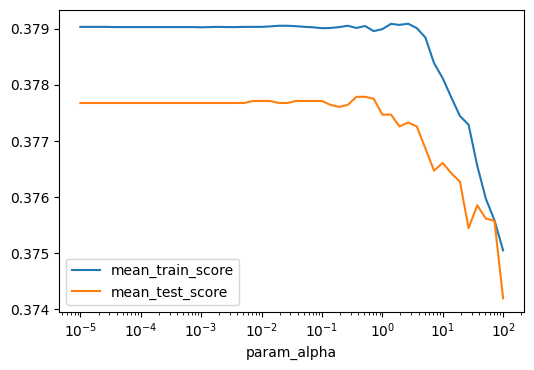

In [ ]:
param_grid = {'alpha': np.logspace(-5, 2, 50)}
grid = GridSearchCV(Ridge(), param_grid, cv=10, return_train_score=True, verbose=3, scoring=score_criterion)
grid.fit(X_train, y_train)
plt.figure(dpi=100)
results = pd.DataFrame(grid.cv_results_)

results.plot('param_alpha', 'mean_train_score', ax=plt.gca())
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())

# gca - get current ax
plt.legend()
plt.xscale("log")

print(grid.best_params_)

score = np.mean(cross_val_score(Ridge(alpha=grid.best_params_['alpha']), X_train, y_train, cv=10, scoring=score_criterion))
result_dic['Ridge'] = (score, grid.best_params_['alpha'])

score

In [30]:
parameters = {'alpha': 0.5179474679231213}
model = Ridge(**parameters)
model.fit(X_train, y_train)

Ridge(alpha=0.5179474679231213)

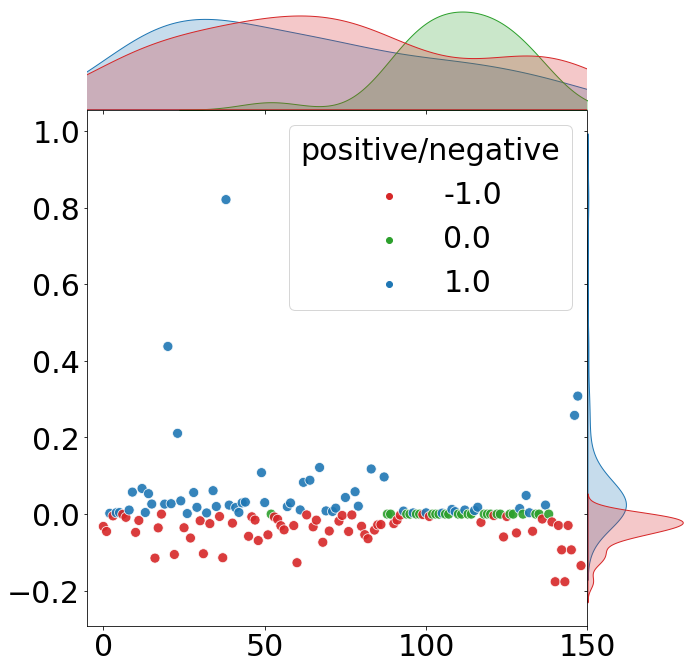

In [34]:
x = [i for i in range(X_train.shape[1])]
y = model.coef_
c_sign = np.sign(model.coef_)

palette = {
    -1: 'tab:red',
    0: 'tab:green',
    1: 'tab:blue',
}

plt_df = pd.DataFrame({'x': x, 'y': y, 'positive/negative': c_sign})
plt.rcParams.update({'font.size': 30})
g = sns.jointplot(x, y, data=plt_df, xlim = (-5, 150), height = 10, hue='positive/negative', space=0, palette=palette, s = 100, alpha = 0.9)


In [14]:
model.coef_

array([-3.20696885e-02, -4.52679663e-02,  2.11475429e-03, -4.61447198e-03,
        3.60613404e-03,  3.99840179e-03, -5.86264502e-04, -8.36439439e-03,
        1.05933821e-02,  5.74139748e-02, -4.76456864e-02, -1.65158298e-02,
        6.69069583e-02,  4.18925993e-03,  5.33388091e-02,  2.63108273e-02,
       -1.14841052e-01, -3.59048023e-02, -7.98582902e-06,  2.61186459e-02,
        4.37659753e-01,  2.71937937e-02, -1.05357761e-01,  2.10856344e-01,
        3.45922537e-02, -3.55800440e-02,  1.47674896e-03, -6.23809887e-02,
        5.63320968e-02,  1.77064532e-02, -1.73329749e-02, -1.03360521e-01,
        3.04839255e-03, -2.48309606e-02,  6.12022857e-02,  1.98928294e-02,
       -6.15214407e-03, -1.13808933e-01,  8.20809940e-01,  2.35186329e-02,
       -2.35186329e-02,  1.71044924e-02,  4.40266903e-03,  2.93808729e-02,
        3.13394478e-02, -5.78491026e-02, -6.96987190e-03, -1.54784809e-02,
       -6.90299873e-02,  1.08221489e-01,  3.00677822e-02, -5.40848179e-02,
        0.00000000e+00, -

3. Lasso

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...alpha=1e-06;, score=(train=0.378, test=0.385) total time=  11.2s
[CV 2/5] END ...alpha=1e-06;, score=(train=0.377, test=0.383) total time=  11.2s
[CV 3/5] END ...alpha=1e-06;, score=(train=0.376, test=0.378) total time=  11.0s
[CV 4/5] END ...alpha=1e-06;, score=(train=0.380, test=0.370) total time=  10.9s
[CV 5/5] END ...alpha=1e-06;, score=(train=0.380, test=0.366) total time=  11.0s
[CV 1/5] END alpha=1.778279410038923e-05;, score=(train=0.378, test=0.385) total time=  10.4s
[CV 2/5] END alpha=1.778279410038923e-05;, score=(train=0.377, test=0.384) total time=  10.0s
[CV 3/5] END alpha=1.778279410038923e-05;, score=(train=0.376, test=0.379) total time=  10.3s
[CV 4/5] END alpha=1.778279410038923e-05;, score=(train=0.380, test=0.369) total time=  10.2s
[CV 5/5] END alpha=1.778279410038923e-05;, score=(train=0.379, test=0.364) total time=  10.6s
[CV 1/5] END alpha=0.00031622776601683794;, score=(train=0.375, t

0.3762829007295488

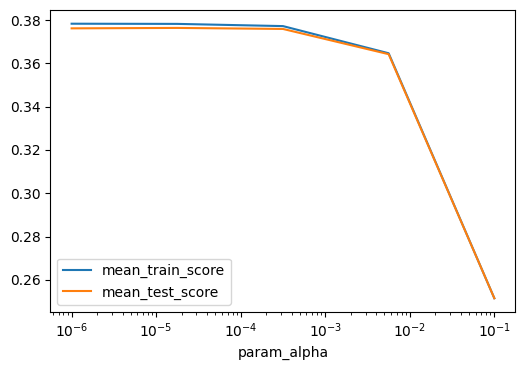

In [15]:
# Takes Too long to run!
param_grid = {'alpha': np.logspace(-6, -1, 5)}
grid = GridSearchCV(Lasso(), param_grid, cv=5, return_train_score=True, verbose=3, scoring=score_criterion)
grid.fit(X_train, y_train)
plt.figure(dpi=100)
results = pd.DataFrame(grid.cv_results_)
results.plot('param_alpha', 'mean_train_score', ax=plt.gca())
results.plot('param_alpha', 'mean_test_score', ax=plt.gca())
# gca - get current ax
plt.legend()
plt.xscale("log")

print(grid.best_params_)

score = np.mean(cross_val_score(Lasso(alpha=grid.best_params_['alpha']), X_train, y_train, cv=10, scoring=score_criterion))
result_dic['Lasso'] = (score, grid.best_params_['alpha'])
score

In [16]:
parameters = {'alpha': 1.778279410038923e-05}
model = Lasso(**parameters)
model.fit(X_train, y_train)

Lasso(alpha=1.778279410038923e-05)

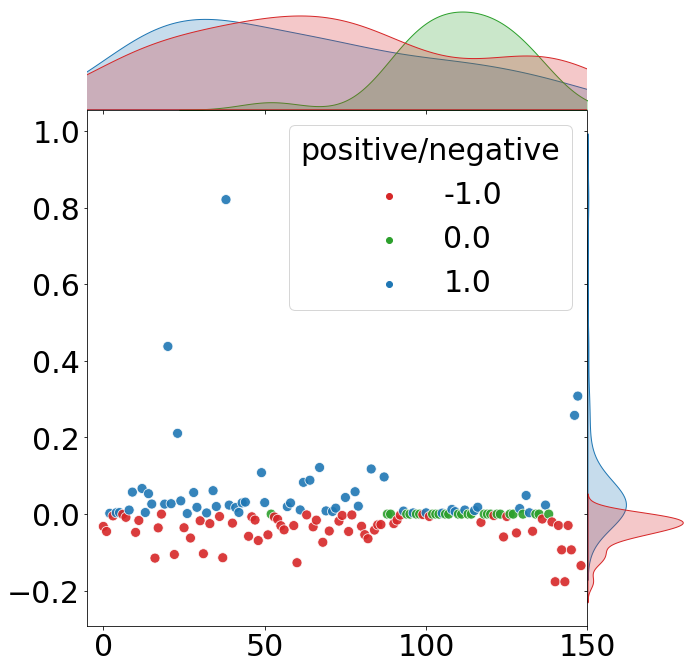

In [35]:
x = [i for i in range(X_train.shape[1])]
y = model.coef_
c_sign = np.sign(model.coef_)

palette = {
    -1: 'tab:red',
    0: 'tab:green',
    1: 'tab:blue',
}

plt_df = pd.DataFrame({'x': x, 'y': y, 'positive/negative': c_sign})
plt.rcParams.update({'font.size': 30})
g = sns.jointplot(x, y, data=plt_df, xlim = (-5, 150), height = 10, hue='positive/negative', space=0, palette=palette, s = 100, alpha = 0.9)


In [18]:
model.coef_

array([-3.18047124e-02, -4.55949562e-02,  0.00000000e+00, -5.63635513e-03,
        1.68863537e-03,  2.40678940e-03, -2.33542329e-03, -1.07910507e-02,
        8.09403079e-03,  5.22303794e-02, -4.77286752e-02, -0.00000000e+00,
        4.04433276e-02, -2.02568157e-02,  2.70428944e-02,  0.00000000e+00,
       -1.27961402e-01, -0.00000000e+00,  2.45250548e-04,  2.77606250e-02,
        4.38275446e-01,  2.91390083e-02, -1.01007605e-01,  2.12921739e-01,
        3.81577696e-02, -3.15671903e-02,  3.93881527e-03, -5.84645813e-02,
        5.49606524e-02,  2.10644133e-02, -1.33609174e-02, -9.89770895e-02,
        0.00000000e+00, -2.33855815e-02,  5.91828968e-02,  2.00227821e-02,
       -6.35749082e-03, -1.14206849e-01,  8.21970345e-01,  3.87381172e-02,
       -1.42583441e-17,  1.66586660e-02,  0.00000000e+00,  2.56563994e-02,
        4.51137707e-03, -5.72632038e-02, -6.67946731e-03, -0.00000000e+00,
       -6.12796772e-02,  1.75870490e-02,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -

4. XGBoost

In [19]:
def mape(dtrain, preds):
    d = preds - dtrain
    h = 1
    scale = 1 + (d / h) ** 2
    scale_sqrt = np.sqrt(scale)
    grad = d / scale_sqrt
    hess = 1 / scale / scale_sqrt
    return grad, hess

parameters = {
    'max_depth'        : np.arange(11, 14),
    'n_estimators'     : np.arange(200, 250, 10),
    'gamma'            : [0],
    'eta'              : [0.1],
    'objective'        : [mape],
}

grid = GridSearchCV(xgb.XGBRegressor(), parameters, cv=10, return_train_score=True)
grid.fit(X_train, y_train)
print(grid.best_params_)

score = np.mean(cross_val_score(xgb.XGBRegressor(**grid.best_params_), X_train, y_train, cv=10, scoring=score_criterion))
result_dic['XGBRegressor'] = (score, grid.best_params_)
score

KeyboardInterrupt: 

In [47]:
parameters = {'eta': 0.1, 'eval_metric': 'mae', 'gamma': 0.1, 'max_depth': 13, 'n_estimators': 190}
model = xgb.XGBRegressor(**parameters)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.1, eval_metric='mae', gamma=0.1, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=13,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=190, n_jobs=12, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

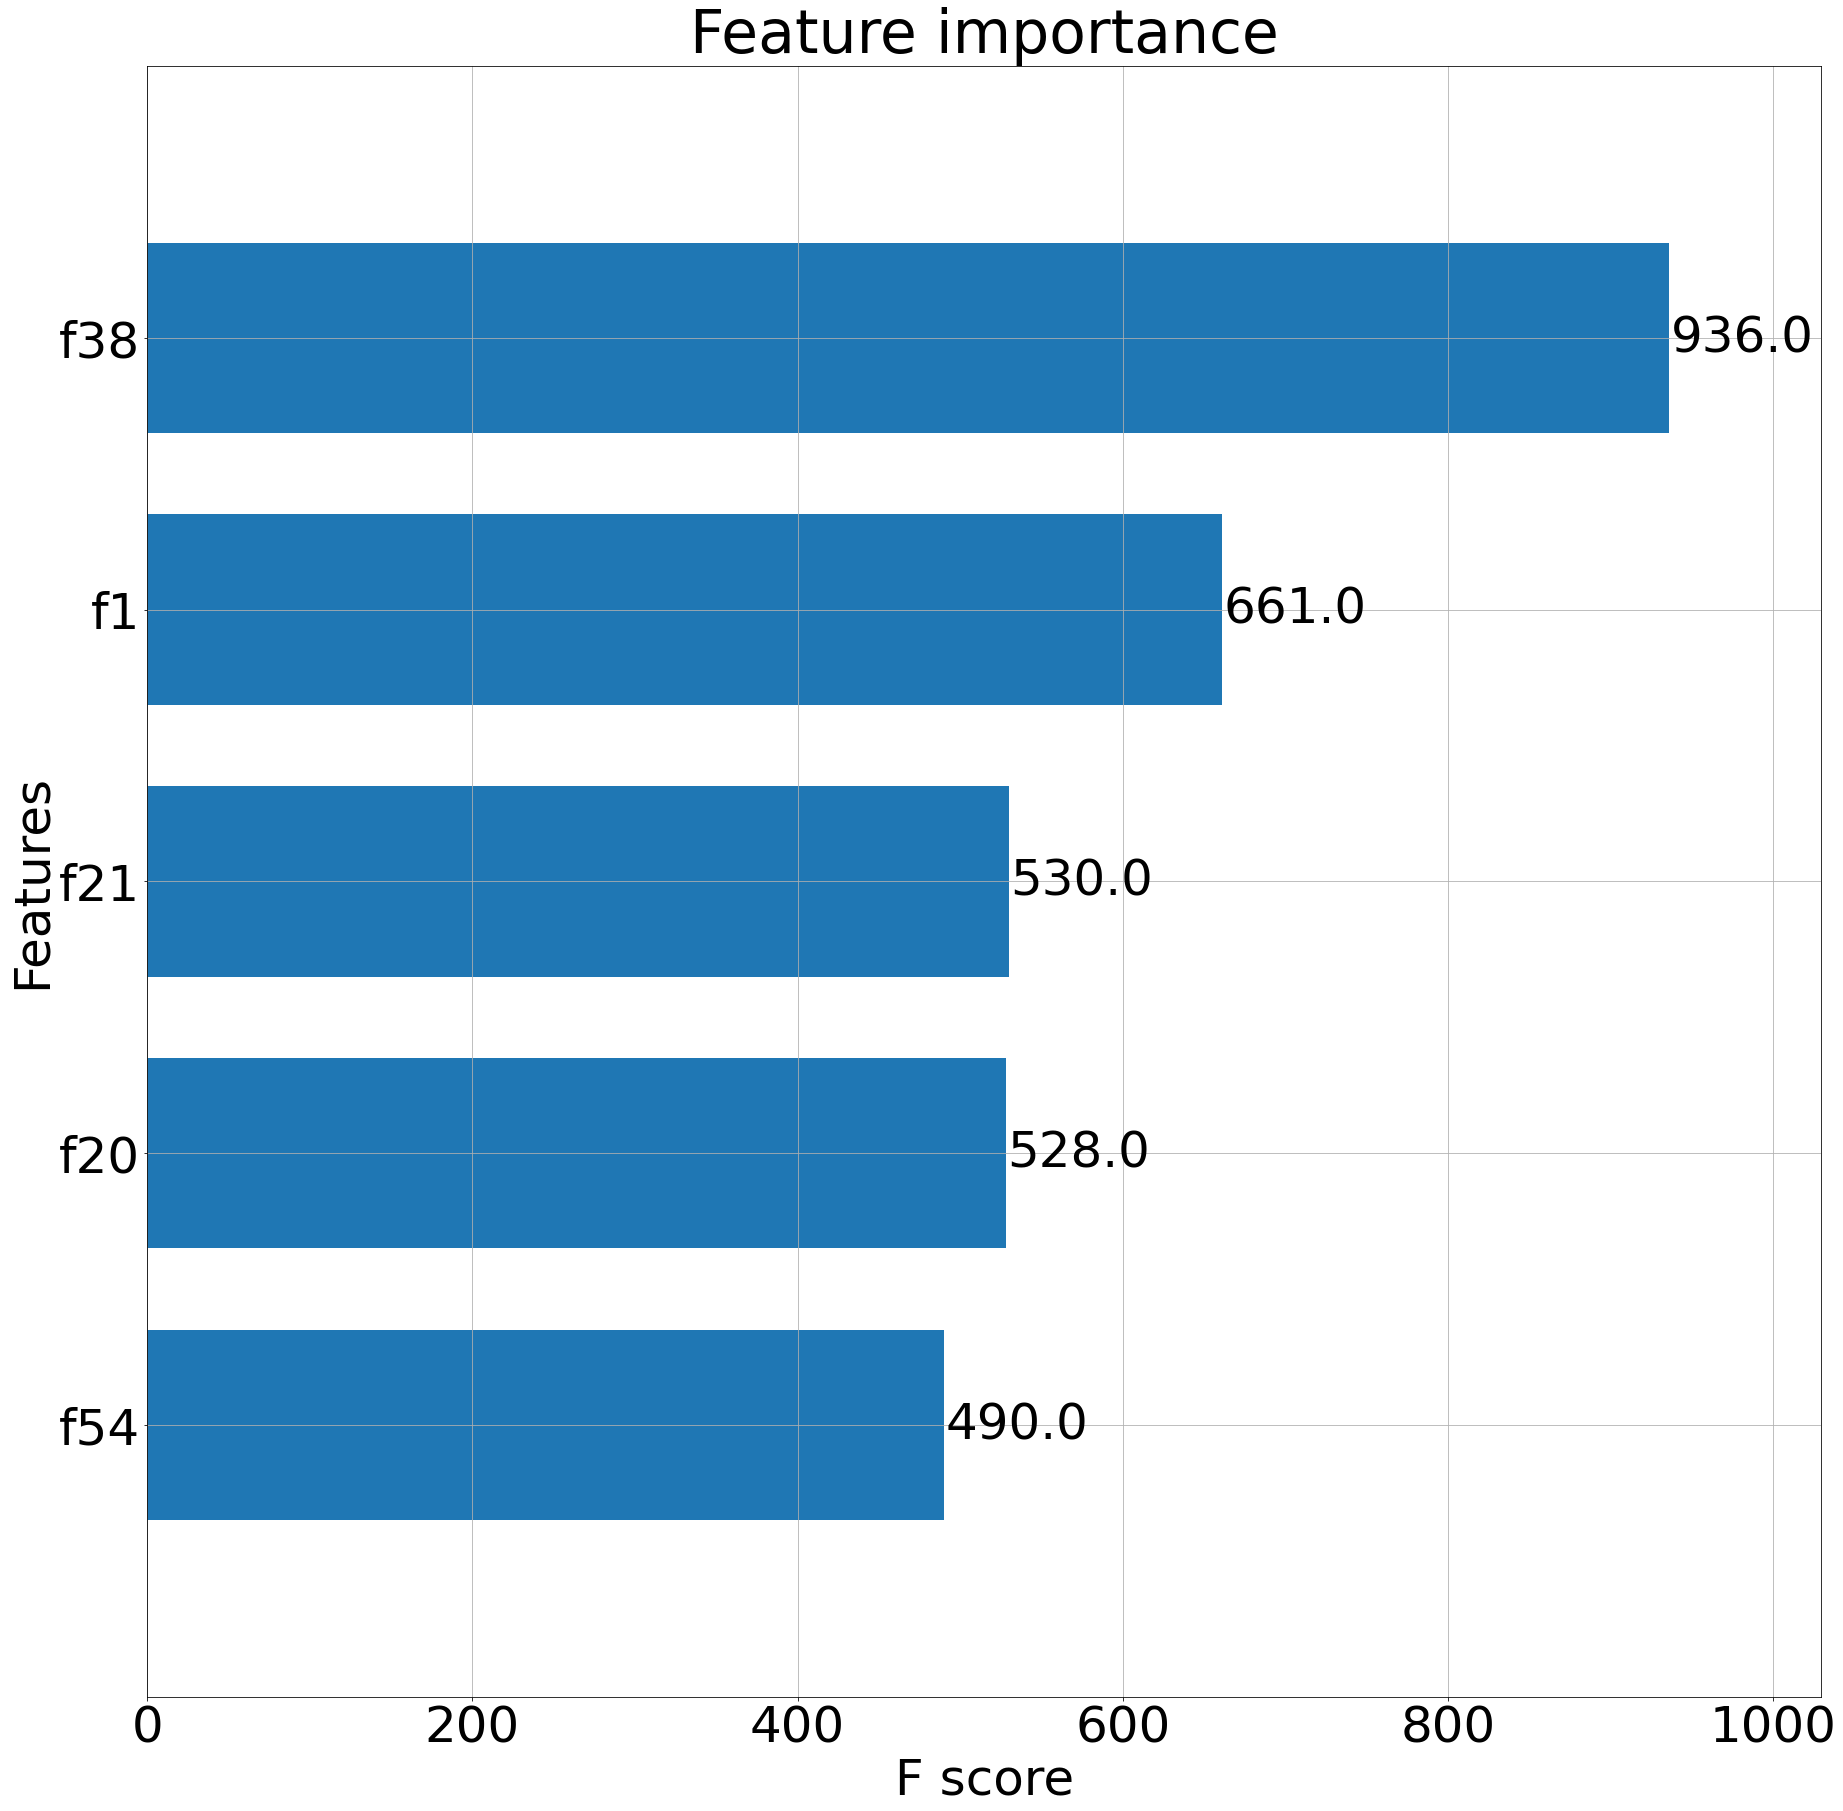

In [48]:
plt.rcParams["figure.figsize"] = (30, 30)
plt.rcParams.update({'font.size': 50})
xgb.plot_importance(model, max_num_features=5, height=0.7)
plt.show()

5. LGB

In [ ]:
parameters = {
    'metric': ['l1'],
    "max_depth": np.arange(16, 20),
    "num_leaves": np.arange(50, 54),  
}

grid = GridSearchCV(lgb.LGBMRegressor(), parameters, cv=10, return_train_score=True, scoring=score_criterion, verbose=3)
grid.fit(X_train, y_train)
print(grid.best_params_)

score = np.mean(cross_val_score(lgb.LGBMRegressor(**grid.best_params_), X_train, y_train, cv=10, scoring=score_criterion))
result_dic['LGBMRegressor'] = (score, grid.best_params_)
score

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] max_depth=16, metric=l1, num_leaves=50 ..........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=16, metric=l1, num_leaves=50, score=(train=0.559, test=0.496), total=   0.3s
[CV] max_depth=16, metric=l1, num_leaves=50 ..........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  max_depth=16, metric=l1, num_leaves=50, score=(train=0.549, test=0.525), total=   0.3s
[CV] max_depth=16, metric=l1, num_leaves=50 ..........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s


[CV]  max_depth=16, metric=l1, num_leaves=50, score=(train=0.554, test=0.515), total=   0.3s
[CV] max_depth=16, metric=l1, num_leaves=50 ..........................
[CV]  max_depth=16, metric=l1, num_leaves=50, score=(train=0.555, test=0.508), total=   0.3s
[CV] max_depth=16, metric=l1, num_leaves=50 ..........................
[CV]  max_depth=16, metric=l1, num_leaves=50, score=(train=0.554, test=0.505), total=   0.3s
[CV] max_depth=16, metric=l1, num_leaves=50 ..........................
[CV]  max_depth=16, metric=l1, num_leaves=50, score=(train=0.556, test=0.506), total=   0.3s
[CV] max_depth=16, metric=l1, num_leaves=50 ..........................
[CV]  max_depth=16, metric=l1, num_leaves=50, score=(train=0.556, test=0.503), total=   0.3s
[CV] max_depth=16, metric=l1, num_leaves=50 ..........................
[CV]  max_depth=16, metric=l1, num_leaves=50, score=(train=0.559, test=0.510), total=   0.3s
[CV] max_depth=16, metric=l1, num_leaves=50 ..........................
[CV]  max_depth=

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:   53.4s finished


{'max_depth': 17, 'metric': 'l1', 'num_leaves': 52}


0.5135302890218749

In [43]:
parameters = {'max_depth': 17, 'metric': 'l1', 'num_leaves': 52}
model = lgb.LGBMRegressor(**parameters)
model.fit(X_train, y_train)

LGBMRegressor(max_depth=17, metric='l1', num_leaves=52)

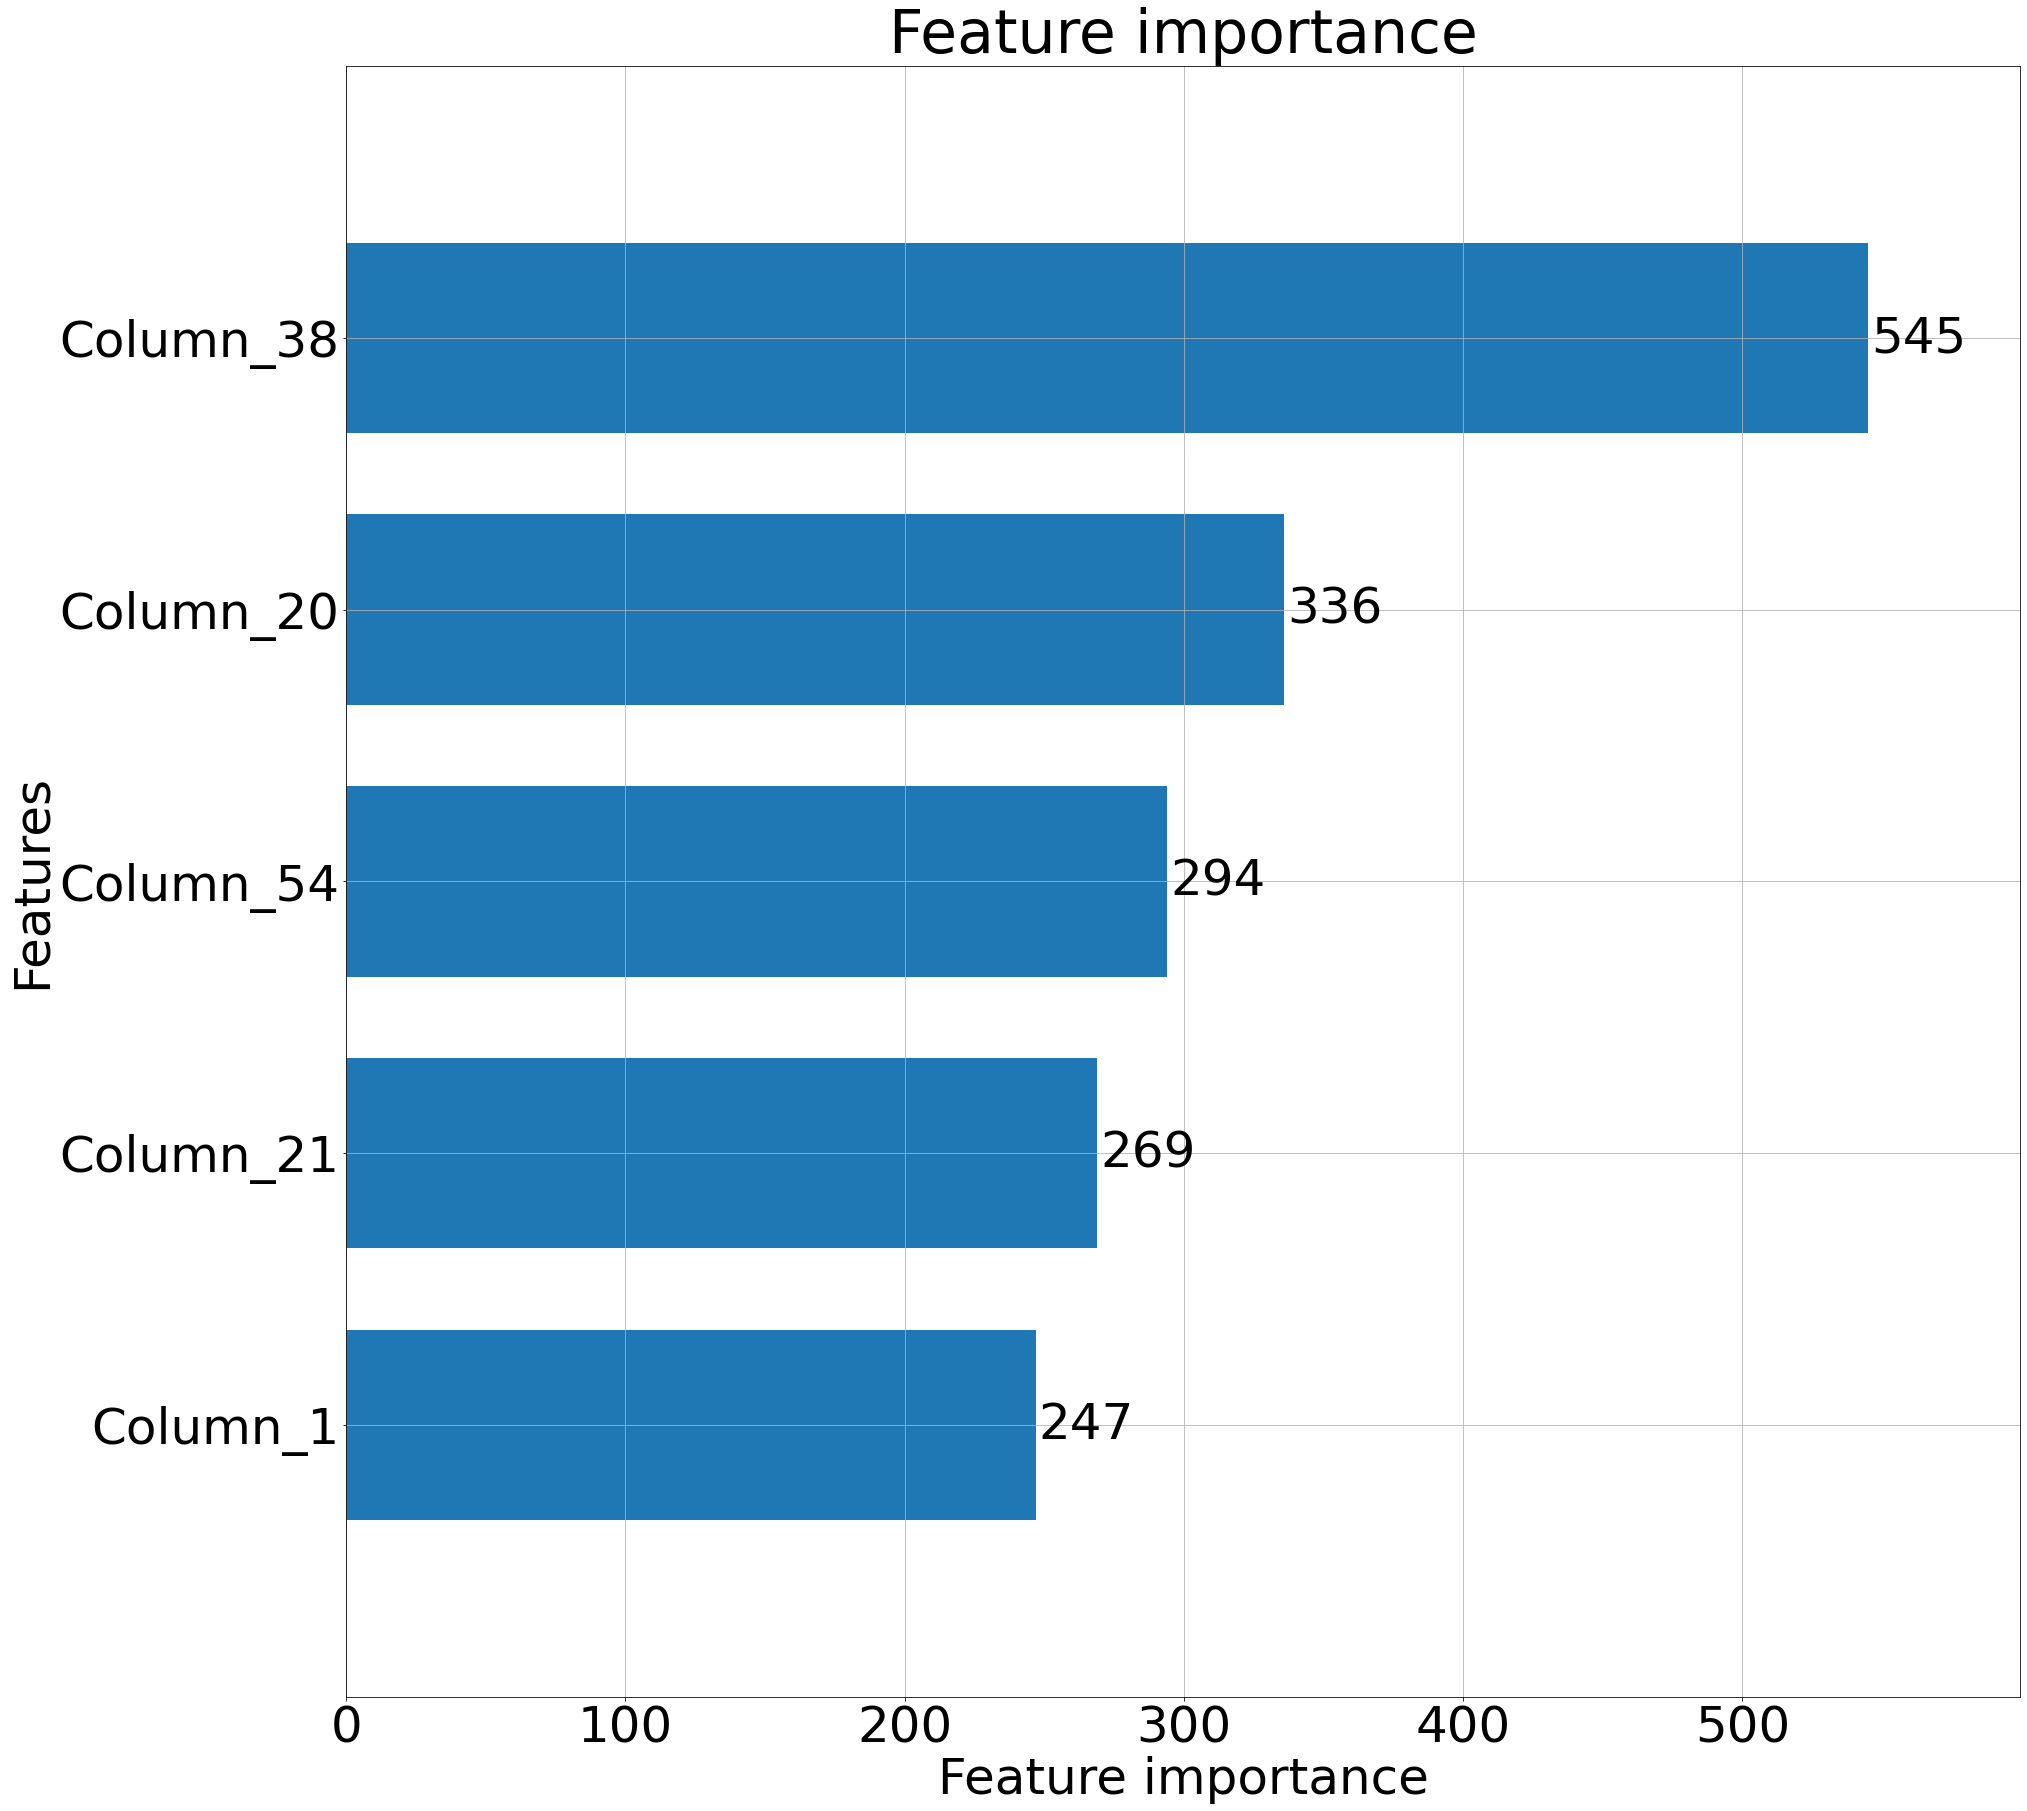

In [45]:
plt.rcParams["figure.figsize"] = (30, 30)
plt.rcParams.update({'font.size': 50})
lgb.plot_importance(model, max_num_features=5, height=0.7)
plt.show()

6. SVR

In [ ]:
# parameters = {
#     "kernel"           : ['rbf'],
#     'degree'           : [2, 3],
#     "gamma"            : ['auto'],
#     'tol'              : [0.001, 0.0005, 0.0001],
#     'C'                : [1, 0.5],
# }

# grid = GridSearchCV(SVR(), parameters, cv=5, return_train_score=True, scoring=score_criterion, verbose=3)
# grid.fit(X_train, y_train)
# print(grid.best_params_)

# score = np.mean(cross_val_score(SVR(), X_train, y_train, cv=5, scoring=score_criterion))
# result_dic['SVR'] = (score, 'default')
# score

model = SVR()
model.fit(X_train, y_train)
score = criterion(model.predict(X_test), y_test)
result_dic['SVR'] = (score, 'default')
score

0.4766638929610223

7. GBR

In [ ]:
para = {
    'alpha': 0.99,
    'learning_rate': 0.1,
    'loss': 'lad',
    'max_depth': 9,
    'max_features': 0.6000000000000001,
    'min_samples_leaf': 14,
    'min_samples_split': 10,
    'n_estimators': 100,
    'subsample': 1.0
}

model = GradientBoostingRegressor(
    alpha=0.99,
    learning_rate=0.1,
    loss='lad',
    max_depth=9,
    max_features=0.6000000000000001,
    min_samples_leaf=14,
    min_samples_split=10,
    n_estimators=100,
    subsample=1.0
    )

score = np.mean(cross_val_score(model, X_train, y_train, cv=10, scoring=score_criterion))
result_dic['GBR'] = (score, para)
score

0.5345630554391204

In [ ]:
# result_dic = {'Linear Regression': (np.nan, None),
#     'Ridge': (0.3777880529240987, 0.5179474679231213),
#     'Lasso': (0.37628290072954884, 1.778279410038923e-05),
#     'XGBRegressor': (0.5248582718245366,
#     {'eta': 0.1,
#     'eval_metric': 'mae',
#     'gamma': 0.1,
#     'max_depth': 13,
#     'n_estimators': 190}),
#     'LGBMRegressor': (0.5135302890218749,
#     {'max_depth': 17, 'metric': 'l1', 'num_leaves': 52}),
#     'SVR': (0.4766638929610223, 'default'),
#     'GBR': (0.5345630554391204,
#     {'alpha': 0.99,
#     'learning_rate': 0.1,
#     'loss': 'lad',
#     'max_depth': 9,
#     'max_features': 0.6000000000000001,
#     'min_samples_leaf': 14,
#     'min_samples_split': 10,
#     'n_estimators': 100,
#     'subsample': 1.0})
# }

result_dic

{'Linear Regression': (nan, None),
 'Ridge': (0.3777880529240987, 0.5179474679231213),
 'Lasso': (0.37628290072954884, 1.778279410038923e-05),
 'XGBRegressor': (0.5248582718245366,
  {'eta': 0.1,
   'eval_metric': 'mae',
   'gamma': 0.1,
   'max_depth': 13,
   'n_estimators': 190}),
 'LGBMRegressor': (0.5135302890218749,
  {'max_depth': 17, 'metric': 'l1', 'num_leaves': 52}),
 'SVR': (0.4766638929610223, 'default'),
 'GBR': (0.5345630554391204,
  {'alpha': 0.99,
   'learning_rate': 0.1,
   'loss': 'lad',
   'max_depth': 9,
   'max_features': 0.6000000000000001,
   'min_samples_leaf': 14,
   'min_samples_split': 10,
   'n_estimators': 100,
   'subsample': 1.0})}

6. Stacking Models: Linear Combination

In [ ]:
model_0 = make_pipeline(
    StackingEstimator(estimator=xgb.XGBRegressor(learning_rate=0.001,
                                                    max_depth=1,
                                                    min_child_weight=2,
                                                    n_estimators=100,
                                                    objective='reg:squarederror',
                                                    subsample=0.6500000000000001)),
    RandomForestRegressor(bootstrap=False,
                            max_features=0.5,
                            min_samples_leaf=2,
                            min_samples_split=2,)
)

model_1 = GradientBoostingRegressor(alpha=0.99,
                                    learning_rate=0.1,
                                    loss='lad',
                                    max_depth=9,
                                    max_features=0.6,
                                    min_samples_leaf=14,
                                    min_samples_split=10,
                                    n_estimators=100,
                                    subsample=1.0)


model_2 = RandomForestRegressor(bootstrap=False,
                                max_features=0.5,
                                min_samples_leaf=2,
                                min_samples_split=2,
                                n_estimators=100
                                )

# models = [model_1, model_2]
models = [model_0, model_1, model_2]

In [ ]:
# Train each model
pred_trains = np.empty((y_train.shape[0],1), int)
for model in models:
    model.fit(X_train, y_train)
    pred_y = model.predict(X_train).reshape(y_train.shape[0],1)
    pred_trains = np.append(pred_trains, pred_y, axis=1)
pred_trains = pred_trains[:,1:]

In [ ]:
# Model Stacking
combine_model = LinearRegression(fit_intercept=False)
combine_model.fit(pred_trains, y_train)
print(combine_model.coef_)
print(combine_model.intercept_)
print(combine_model.score(pred_trains, y_train))

[ 0.47385897 -0.16159565  0.68784809]
0.0
0.999358463737241


In [ ]:
# Get individual prediction
pred_tests = np.empty((y_test.shape[0],1), int)
for model in models:
    print(model)
    pred_y= model.predict(X_test).reshape(y_test.shape[0],1)
    print('score', criterion(pred_y.flatten(), y_test.flatten()))
    print()
    pred_tests = np.append(pred_tests, pred_y, axis=1)
pred_tests = pred_tests[:,1:]

Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=XGBRegressor(base_score=0.5,
                                                          booster='gbtree',
                                                          colsample_bylevel=1,
                                                          colsample_bynode=1,
                                                          colsample_bytree=1,
                                                          enable_categorical=False,
                                                          gamma=0, gpu_id=-1,
                                                          importance_type=None,
                                                          interaction_constraints='',
                                                          learning_rate=0.001,
                                                          max_delta_step=0,
                                                          max_depth=1,
                       

In [ ]:
combine_pred_test = combine_model.predict(pred_tests)
print(combine_model)
criterion(combine_pred_test, y_test)

LinearRegression(fit_intercept=False)


0.5469115997773577

<font size=20> 都是菜鸡

10. Stacking Models by Weighted Average

In [ ]:
model_XGB = make_pipeline(
    StackingEstimator(estimator=xgb.XGBRegressor(learning_rate=0.001,
                                                    max_depth=1,
                                                    min_child_weight=2,
                                                    n_estimators=100,
                                                    objective='reg:squarederror',
                                                    subsample=0.6500000000000001)),
    RandomForestRegressor(bootstrap=False,
                            max_features=0.5,
                            min_samples_leaf=2,
                            min_samples_split=2,)
)


model_GBR = GradientBoostingRegressor(alpha=0.99,
                                    learning_rate=0.1,
                                    loss='lad',
                                    max_depth=9,
                                    max_features=0.6,
                                    min_samples_leaf=14,
                                    min_samples_split=10,
                                    n_estimators=100,
                                    subsample=1.0)


model_RFR = RandomForestRegressor(bootstrap=False,
                                max_features=0.5,
                                min_samples_leaf=2,
                                min_samples_split=2,
                                n_estimators=100
                                )

final_model = [model_XGB, model_GBR, model_RFR]

In [ ]:
# Train each model
pred_trains = np.empty((y_train.shape[0],1), int)
for model in final_model:
    model.fit(X_train, y_train)
    pred_y = model.predict(X_train).reshape(y_train.shape[0],1)
    pred_trains = np.append(pred_trains, pred_y, axis=1)
pred_trains = pred_trains[:,1:]

<Figure size 1440x1440 with 0 Axes>

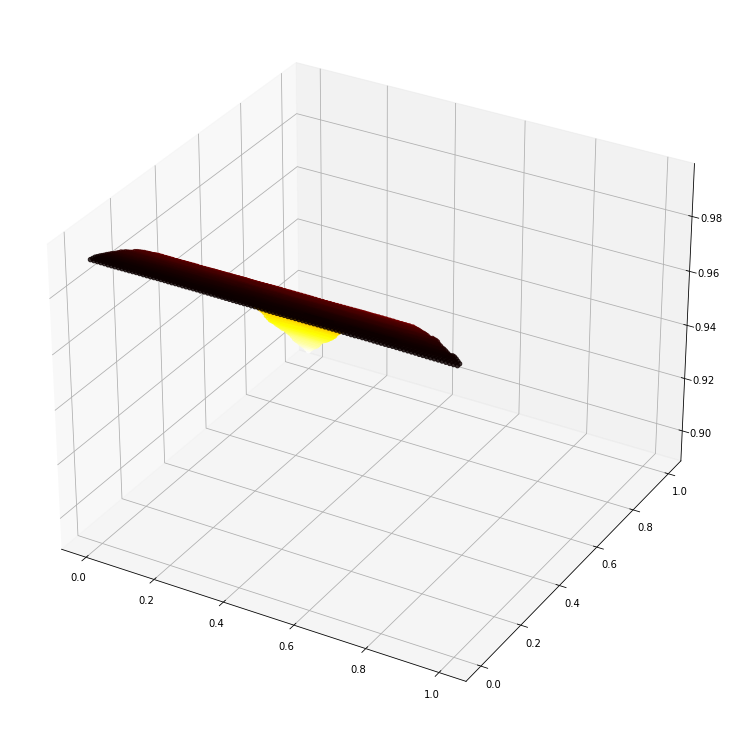

[0.3, 0.0]


0.9919525212439052

In [ ]:
plt.cla()
plt.clf()
plt.rcParams["figure.figsize"] = (10, 10)

if len(final_model) == 2:
    prediction_1 = pred_trains[:,0]
    prediction_2 = pred_trains[:,1]
    xx = prediction_1 - prediction_2
    yy = y_train - prediction_2
else:
    prediction_1 = pred_trains[:,0]
    prediction_2 = pred_trains[:,1]
    prediction_3 = pred_trains[:,2]
    x = []
    y = []
    z = []
    best = [0, 0]
    max_acc = -1
    for w1 in np.arange(0, 1.01, 0.01):
        for w2 in np.arange(0, 1.01 - w1, 0.01):
            final_pred = w1 * prediction_1 + w2 * prediction_2 + (1 - w1 - w2) * prediction_3
            acc = criterion(final_pred, y_train)
            x.append(w1)
            y.append(w2)
            z.append(acc)
            if acc > max_acc:
                best = [w1, w2]
                max_acc = acc
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c = z, alpha = 0.8, cmap=plt.cm.hot_r)
    plt.show()
print(best)
max_acc

In [ ]:
if len(final_model) == 2:
    weighted_model = LinearRegression(fit_intercept=False)
    weighted_model.fit(xx.reshape(-1,1), yy.reshape(-1,1))
    weighted_model.coef_[0,0]

In [ ]:
# Training set acc
if len(final_model) == 2:
    w = weighted_model.coef_[0,0]
    print('XGB:', criterion(prediction_1, y_train))
    print('SGDReg:', criterion(prediction_2, y_train))
    weighted_prediction_train = w * prediction_1 + (1-w) * prediction_2
    print('Combined:', criterion(weighted_prediction_train, y_train))

Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=XGBRegressor(base_score=0.5,
                                                          booster='gbtree',
                                                          colsample_bylevel=1,
                                                          colsample_bynode=1,
                                                          colsample_bytree=1,
                                                          enable_categorical=False,
                                                          gamma=0, gpu_id=-1,
                                                          importance_type=None,
                                                          interaction_constraints='',
                                                          learning_rate=0.001,
                                                          max_delta_step=0,
                                                          max_depth=1,
                       

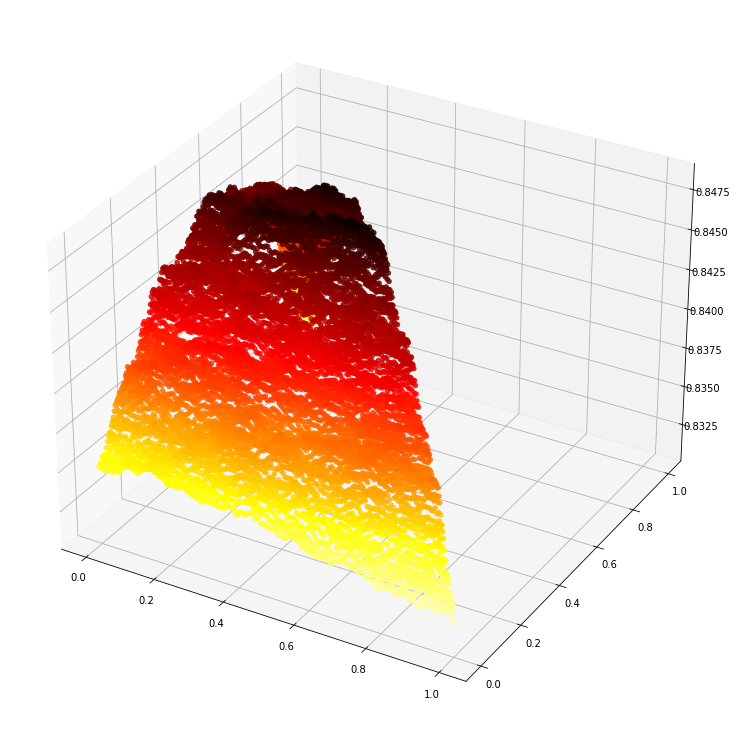

[0.435, 0.485]


0.8478975794358528

In [ ]:
pred_tests = np.empty((y_test.shape[0],1), int)
for model in final_model:
    print(model)
    pred_y= model.predict(X_test).reshape(y_test.shape[0],1)
    print(criterion(y_test, pred_y.flatten()))
    pred_tests = np.append(pred_tests, pred_y, axis=1)
pred_tests = pred_tests[:,1:]

if len(final_model) == 2:
    print("weighted predition")
    weighted_prediction_test = w * pred_tests[:,0] + (1-w) * pred_tests[:,1]
    print(criterion(weighted_prediction_test.flatten(), y_test))
    
else:
    prediction_1 = pred_tests[:,0]
    prediction_2 = pred_tests[:,1]
    prediction_3 = pred_tests[:,2]
    x = []
    y = []
    z = []
    best = [0, 0]
    max_acc = -1
    for w1 in np.arange(0, 1.005, 0.005):
        for w2 in np.arange(0, 1.005 - w1, 0.005):
            final_pred = w1 * prediction_1 + w2 * prediction_2 + (1 - w1 - w2) * prediction_3
            acc = criterion(final_pred, y_test)
            x.append(w1)
            y.append(w2)
            z.append(acc)
            if acc > max_acc:
                best = [w1, w2]
                max_acc = acc
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x, y, z, c = z, alpha = 0.8, cmap=plt.cm.hot_r)
    plt.show()
print(best)
max_acc